This notebook addresses a flexible job shop scheduling problem. The objective studied is minimizing the completion time of latest job (makespan).

The Flexible Job Shop Problem (FJSP) is an extension of job shop scheduling problem which allows an operation to be processed by any machine from a given machine set.  Each job is associated with a set of operations which need to be processed in a specific order (known as precedence constraints). Only one operation in a job can be processed at a given time and machines can only process one job at a time.

This problem is known to be NP-hard. IBM ILOG CPLEX Optimization Studio includes solvers for both Mathematical and Constraint Programming. Constraint Programming is particularly efficient and useful to tackle detailed scheduling problems. By using docplex.cp python package, you can easily formulate and solve scheduling problems in python notebooks. Below is an example formulation with randomly generated sample data to provide a better understanding of the problem and the model.

In [1]:
nbrOfJobs = 5
jobs_list = [*range(0, nbrOfJobs)] 

In [2]:
nbrOfMachines = 3
machines_list = [*range(0, nbrOfMachines)] 

In [3]:
# randomly generate set of operations for each job
import pandas as pd
import random
minNbrOfOpsPerJob=1
maxNbrOfOpsPerJob=3
NbrofOps_list = [random.randint(minNbrOfOpsPerJob, maxNbrOfOpsPerJob) for j in jobs_list]
JobsOperationsTable = pd.DataFrame(columns=['op_id', 'job', 'position'])
opid=0
for j in jobs_list:
    for o in range(1, NbrofOps_list[j]+1):
        JobsOperationsTable=JobsOperationsTable.append({'op_id': 'opr_'+str(opid),'job':j,'position':o }, ignore_index=True)
        opid=opid+1
from collections import namedtuple
TJobsOperations = namedtuple("TJobsOperations", ["op_id", "job", "position"])
JobsOperations = [TJobsOperations(*joboperations_row) for joboperations_row in JobsOperationsTable.itertuples(index=False)]
print(JobsOperationsTable)

   op_id job position
0  opr_0   0        1
1  opr_1   1        1
2  opr_2   1        2
3  opr_3   1        3
4  opr_4   2        1
5  opr_5   3        1
6  opr_6   4        1


In [4]:
# randomly generate alternative machines and associated processing times for each job operation
OperationMachinesTable = pd.DataFrame(columns=['op_id', 'machine', 'proc_time'])
minProcessingTime=10
maxProcessingTime=40
for jo in JobsOperations:
    NbrOfCapableMachines = random.randint(1, nbrOfMachines)
    machine_sequence=random.sample(machines_list, NbrOfCapableMachines)
    for m in range(0, NbrOfCapableMachines):
        OperationMachinesTable=OperationMachinesTable.append({'op_id': jo.op_id,'machine':machine_sequence[m],'proc_time':random.randint(minProcessingTime, maxProcessingTime)}, ignore_index=True)
TOperationMachines = namedtuple("TOperationMachines", ['op_id', 'machine', 'proc_time'])
OperationMachines = [TOperationMachines(*operationmachines_row) for operationmachines_row in OperationMachinesTable.itertuples(index=False)]
print(OperationMachinesTable)

    op_id machine proc_time
0   opr_0       1        23
1   opr_0       2        29
2   opr_0       0        24
3   opr_1       0        21
4   opr_1       2        31
5   opr_1       1        37
6   opr_2       0        13
7   opr_2       2        17
8   opr_2       1        30
9   opr_3       0        36
10  opr_3       1        25
11  opr_4       2        20
12  opr_4       0        29
13  opr_4       1        35
14  opr_5       0        14
15  opr_6       1        25
16  opr_6       0        34


In [5]:
from docplex.cp.model import *
mdl = CpoModel(name='parallelMachineScheduling_FlexibleJobShop') 

In [6]:
# define interval variables
jobops_itv_vars = {}
for jo in JobsOperations:
    jobops_itv_vars[(jo.op_id,jo.job,jo.position)] = mdl.interval_var(name="operation {} job {} position {}".format(jo.op_id,jo.job,jo.position))

opsmchs_itv_vars = {}
for om in OperationMachines:
    opsmchs_itv_vars[(om.op_id,om.machine)] = mdl.interval_var(optional=True, size=om.proc_time, name="operation {} machine {}".format(om.op_id,om.machine))

In [7]:
#minimize makespan
objective = mdl.max([mdl.end_of(opsmchs_itv_vars[(op_id, machine)]) for (op_id, machine) in opsmchs_itv_vars])
mdl.add(mdl.minimize(objective)) 

In [8]:
# Force no overlap for operations executed on a same machine
machine_operations = [[] for m in machines_list]
for (op_id, machine) in opsmchs_itv_vars:
    machine_operations[machine].append(opsmchs_itv_vars[(op_id, machine)])
for mops in machine_operations:
    mdl.add(mdl.no_overlap(mops))

In [9]:
#Each operation must start after the end of the predecessor
previuosops=dict()
for jo1 in JobsOperations: 
    for jo2 in JobsOperations: 
        if jo1.job==jo2.job and jo1.position+1==jo2.position:
            previuosops[jo2]=jo1.op_id
for j in jobs_list:
    for jo in JobsOperations: 
        if jo.job==j and jo.position>=2:            
            mdl.add(mdl.end_before_start(jobops_itv_vars[(previuosops[jo],jo.job, jo.position-1)], jobops_itv_vars[(jo.op_id,jo.job, jo.position)]))

In [10]:
#job operation intervals can only take value if one of alternative operation-machines intervals take value
for (op_id, job, position) in jobops_itv_vars:
    mdl.add(mdl.alternative(jobops_itv_vars[(op_id, job, position)], [opsmchs_itv_vars[(o, m)] for (o, m) in opsmchs_itv_vars if (o == op_id)],1))

In [11]:
msol= mdl.solve(log_output=True)

In [12]:
print("Solution: ")
msol.print_solution()

Solution: 
-------------------------------------------------------------------------------
Model constraints: 12, variables: integer: 0, interval: 24, sequence: 3
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.35 sec
-------------------------------------------------------------------------------
Objective values: (59,), bounds: (59,), gaps: (0,)
operation opr_0 job 0 position 1: (start=0, end=29, size=29, length=29)
operation opr_0 machine 0: absent
operation opr_0 machine 1: absent
operation opr_0 machine 2: (start=0, end=29, size=29, length=29)
operation opr_1 job 1 position 1: (start=0, end=21, size=21, length=21)
operation opr_1 machine 0: (start=0, end=21, size=21, length=21)
operation opr_1 machine 1: absent
operation opr_1 machine 2: absent
operation opr_2 job 1 position 2: (start=21, end=34, size=13, length=13)
operation opr_2 machine 0: (start=21, end=34, size=13, length=13)
operatio

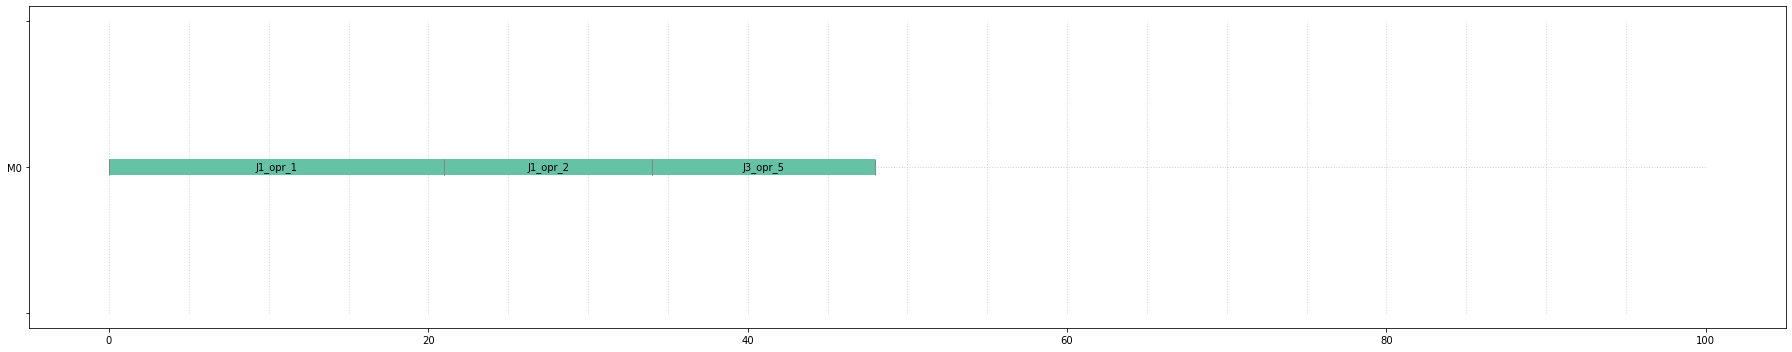

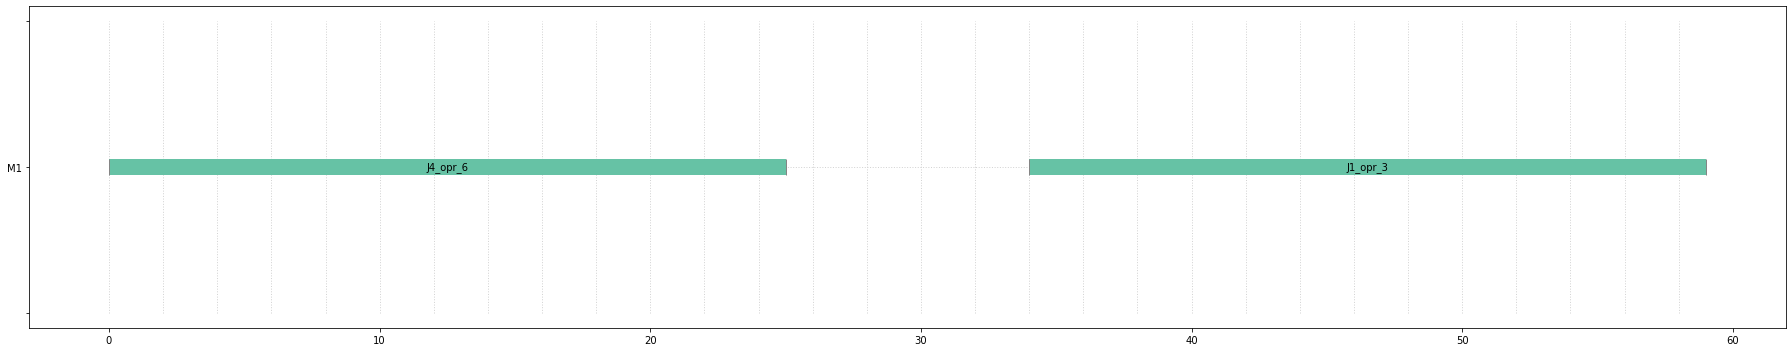

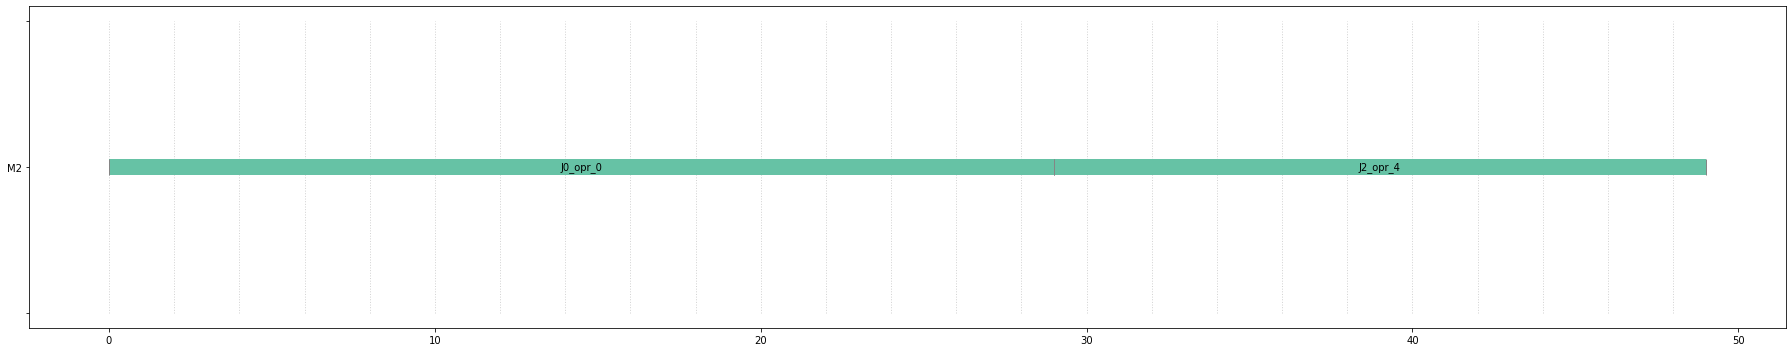

In [13]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5

if msol and visu.is_visu_enabled():
    visu.timeline("Solution Schedule", 0, 100)
    for m in machines_list:
        visu.sequence(name='M' + str(m))
        for (op_id, job, position) in jobops_itv_vars: 
            for (o, mch) in opsmchs_itv_vars: 
                itv2 = msol.get_var_solution(opsmchs_itv_vars[(o, mch)]) 
                if op_id==o and m==mch and itv2.is_present():
                    itv = msol.get_var_solution(jobops_itv_vars[(op_id, job, position)]) 
                    visu.interval(itv,m,'J' + str(job) + '_' + str(op_id))
        visu.show()
